# Numerical Methods for Ordinary Differential Equations
# RK4 vs Verlet (Leapfrog): Theory and Applications

**PSS Session: Homework 2 Preparation**

---

## Overview

This notebook provides a comprehensive guide to two fundamental numerical methods for solving ODEs:
1. **Runge-Kutta 4th Order (RK4)** - General-purpose, high-accuracy method
2. **Verlet/Leapfrog** - Symplectic method for Hamiltonian systems

### Your Homework Problem

You are solving a **two-body system** with gravitational-like forces:

$$\ddot{\vec{x}} = \vec{F}(\vec{x}, \vec{y}) = \frac{\vec{y} - \vec{x}}{|\vec{y} - \vec{x}|^3}$$

$$\ddot{\vec{y}} = \vec{G}(\vec{x}, \vec{y}) = -\alpha \vec{F}(\vec{x}, \vec{y})$$

where $\vec{x}, \vec{y} \in \mathbb{R}^2$ (so **8-dimensional state space** total).

**Key property:** This is a **Hamiltonian system** with conserved energy:

$$E = -\frac{1}{|\vec{x}-\vec{y}|} + \frac{|\dot{\vec{x}}|^2}{2} + \frac{|\dot{\vec{y}}|^2}{2\alpha}$$

### Today's Goals

1. Understand **when** to use RK4 vs Verlet
2. Master the **Leapfrog algorithm** with detailed derivation
3. See **three demonstration problems**:
   - Damped driven pendulum (non-conservative)
   - Coupled spring-mass system (conservative, similar to homework)
   - Van der Pol oscillator (nonlinear limit cycles)
4. Learn **energy conservation analysis**
5. Understand **step size selection**

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Enhanced plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

print("✓ Libraries loaded")
print("✓ Plotting configured")

✓ Libraries loaded
✓ Plotting configured


# Part 1: Theoretical Foundation

## 1.1 The Problem: Second-Order ODEs

Many physics problems involve Newton's second law:

$$m\frac{d^2\vec{x}}{dt^2} = \vec{F}(\vec{x}, \dot{\vec{x}}, t)$$

Setting $m=1$ for simplicity:

$$\ddot{\vec{x}} = \vec{a}(\vec{x}, \dot{\vec{x}}, t)$$

where $\vec{a}$ is the acceleration.

### Converting to First-Order System

Define velocity: $\vec{v} = \dot{\vec{x}}$

Then:
$$\begin{cases}
\frac{d\vec{x}}{dt} = \vec{v} \\
\frac{d\vec{v}}{dt} = \vec{a}(\vec{x}, \vec{v}, t)
\end{cases}$$

**State vector:** $\vec{y} = [\vec{x}, \vec{v}]^T$

**Generic form:** $\frac{d\vec{y}}{dt} = \vec{f}(\vec{y}, t)$

---

## 1.2 Runge-Kutta 4th Order (RK4)

### The Algorithm

Given: $\frac{d\vec{y}}{dt} = \vec{f}(\vec{y}, t)$ with $\vec{y}(t_n) = \vec{y}_n$

Find: $\vec{y}_{n+1} = \vec{y}(t_n + h)$ where $h$ is the time step.

**Four-stage process:**

$$\boxed{\begin{align}
\vec{k}_1 &= \vec{f}(\vec{y}_n, t_n) \\
\vec{k}_2 &= \vec{f}\left(\vec{y}_n + \frac{h}{2}\vec{k}_1, t_n + \frac{h}{2}\right) \\
\vec{k}_3 &= \vec{f}\left(\vec{y}_n + \frac{h}{2}\vec{k}_2, t_n + \frac{h}{2}\right) \\
\vec{k}_4 &= \vec{f}\left(\vec{y}_n + h\vec{k}_3, t_n + h\right) \\
\vec{y}_{n+1} &= \vec{y}_n + \frac{h}{6}\left(\vec{k}_1 + 2\vec{k}_2 + 2\vec{k}_3 + \vec{k}_4\right)
\end{align}}$$

### Interpretation

- $\vec{k}_1$: Slope at beginning of interval
- $\vec{k}_2$: Slope at midpoint using Euler step with $\vec{k}_1$
- $\vec{k}_3$: Improved slope at midpoint using $\vec{k}_2$
- $\vec{k}_4$: Slope at end using $\vec{k}_3$

**Weighted average:** The final step uses a weighted combination emphasizing the midpoint slopes.

### Properties

| Property | Value |
|----------|-------|
| **Local truncation error** | $O(h^5)$ |
| **Global error** | $O(h^4)$ |
| **Function evaluations** | 4 per step |
| **Symplectic?** | No |
| **Best for** | General-purpose, non-conservative systems |

### Example: Simple Calculation

Consider $\frac{dy}{dt} = -y$, $y(0) = 1$, $h = 0.1$

**Exact solution:** $y(t) = e^{-t}$, so $y(0.1) = e^{-0.1} \approx 0.904837$

**RK4 calculation:**

$$\begin{align}
k_1 &= f(1, 0) = -1 \\
k_2 &= f(1 + 0.05 \cdot (-1), 0.05) = f(0.95, 0.05) = -0.95 \\
k_3 &= f(1 + 0.05 \cdot (-0.95), 0.05) = f(0.9525, 0.05) = -0.9525 \\
k_4 &= f(1 + 0.1 \cdot (-0.9525), 0.1) = f(0.90475, 0.1) = -0.90475 \\
y_1 &= 1 + \frac{0.1}{6}(-1 - 1.9 - 1.905 - 0.90475) \\
&= 1 - 0.09516 = 0.90484
\end{align}$$

**Error:** $|0.90484 - 0.904837| \approx 3 \times 10^{-6}$ (excellent!)

---

## 1.3 Verlet / Leapfrog Method: Deep Dive

### Motivation: Why Symplectic Methods?

For **Hamiltonian systems** (conservative), we want methods that:
1. Preserve energy over long timescales
2. Preserve phase space volume (Liouville's theorem)
3. Are time-reversible

**RK4 fails these requirements!** Even though it's 4th-order accurate, energy drifts.

### The Special Form

Leapfrog works for systems where acceleration depends **only on position**:

$$\ddot{\vec{x}} = \vec{a}(\vec{x})$$

**Examples:**
- Gravity: $\vec{a} = -\frac{GM}{r^2}\hat{r}$
- Springs: $\vec{a} = -k\vec{x}$
- Your homework: $\vec{a} = \vec{F}(\vec{x}, \vec{y})$ where $\vec{y}$ is another position

---

### Derivation from Taylor Series

#### Forward Position Expansion

$$\vec{x}(t + h) = \vec{x}(t) + h\dot{\vec{x}}(t) + \frac{h^2}{2}\ddot{\vec{x}}(t) + \frac{h^3}{6}\dddot{\vec{x}}(t) + O(h^4)$$

$$\vec{x}(t + h) = \vec{x}(t) + h\vec{v}(t) + \frac{h^2}{2}\vec{a}(t) + O(h^3)$$

#### Backward Position Expansion

$$\vec{x}(t - h) = \vec{x}(t) - h\vec{v}(t) + \frac{h^2}{2}\vec{a}(t) + O(h^3)$$

#### Adding Forward and Backward

$$\vec{x}(t + h) + \vec{x}(t - h) = 2\vec{x}(t) + h^2\vec{a}(t) + O(h^4)$$

$$\boxed{\vec{x}_{n+1} = 2\vec{x}_n - \vec{x}_{n-1} + h^2\vec{a}_n}$$

This is the **Verlet position update** (requires two previous positions).

---

### Leapfrog Form (Velocity-Explicit)

To get velocities explicitly, use **staggered time grid**:
- Positions: $\vec{x}_n$ at $t = nh$
- Velocities: $\vec{v}_{n+1/2}$ at $t = (n + \frac{1}{2})h$

#### Velocity Midpoint Formula

From $\vec{v}(t) = \dot{\vec{x}}(t)$:

$$\vec{v}\left(t + \frac{h}{2}\right) \approx \frac{\vec{x}(t + h) - \vec{x}(t)}{h}$$

#### Update Equations

**Step 1:** Update velocity by half-step ("kick")

$$\vec{v}_{n+1/2} = \vec{v}_n + \frac{h}{2}\vec{a}(\vec{x}_n)$$

**Step 2:** Update position using midpoint velocity ("drift")

$$\vec{x}_{n+1} = \vec{x}_n + h\vec{v}_{n+1/2}$$

**Step 3:** Complete velocity update ("kick")

$$\vec{v}_{n+1} = \vec{v}_{n+1/2} + \frac{h}{2}\vec{a}(\vec{x}_{n+1})$$

$$\boxed{\text{Kick-Drift-Kick Algorithm}}$$

---

### Why "Leapfrog"?

```
Time:     n-1/2      n        n+1/2      n+1      n+3/2
         ----o------o--------o--------o--------o----
Position:           x_n                x_{n+1}
Velocity:    v_{n-1/2}        v_{n+1/2}        v_{n+3/2}
```

Positions and velocities "leap" over each other!

---

### Mathematical Properties

#### 1. Time Reversibility

Replace $h \to -h$:

$$\vec{v}_{n-1/2} = \vec{v}_n - \frac{h}{2}\vec{a}(\vec{x}_n)$$
$$\vec{x}_{n-1} = \vec{x}_n - h\vec{v}_{n-1/2}$$
$$\vec{v}_{n-1} = \vec{v}_{n-1/2} - \frac{h}{2}\vec{a}(\vec{x}_{n-1})$$

This recovers the previous state **exactly** (up to rounding error).

#### 2. Symplectic Property

The Leapfrog map $(\vec{x}_n, \vec{v}_n) \to (\vec{x}_{n+1}, \vec{v}_{n+1})$ preserves the symplectic 2-form:

$$\omega = d\vec{x} \wedge d\vec{v}$$

**Consequence:** Phase space volume is conserved (Liouville's theorem).

#### 3. Energy Conservation

For Hamiltonian $H(\vec{x}, \vec{v}) = \frac{1}{2}m|\vec{v}|^2 + U(\vec{x})$:

$$|H_n - H_0| = O(h^2)$$

**Crucially:** Error is **bounded**, not accumulating!

$$H_n = H_0 + \epsilon_n, \quad |\epsilon_n| \leq C h^2$$

for all $n$, unlike RK4 where $H_n \sim H_0 + \alpha n h^4$ (grows with time).

#### 4. Accuracy

| Property | Order |
|----------|-------|
| **Local truncation error** | $O(h^3)$ |
| **Global error** | $O(h^2)$ |
| **Energy error** | $O(h^2)$ (bounded) |

---

### Comparison Table

| Feature | RK4 | Leapfrog |
|---------|-----|----------|
| **Accuracy (position)** | $O(h^4)$ | $O(h^2)$ |
| **Energy conservation** | Drifts | Bounded |
| **Symplectic** | No | Yes |
| **Time-reversible** | No | Yes |
| **Function evals/step** | 4 | 2 |
| **Works for $a(x,v,t)$** | Yes | No |
| **Best for** | General ODEs | Hamiltonian systems |

---

## 1.4 Simple Example: 1D Harmonic Oscillator

### Problem Setup

$$\frac{d^2x}{dt^2} = -\omega^2 x$$

with $x(0) = A$, $\dot{x}(0) = 0$.

### Exact Solution

$$x(t) = A\cos(\omega t)$$
$$v(t) = -A\omega\sin(\omega t)$$

### Energy

$$E = \frac{1}{2}v^2 + \frac{1}{2}\omega^2 x^2 = \frac{1}{2}\omega^2 A^2 = \text{constant}$$

Let's verify this with Leapfrog!

---

In [2]:
# 1D Harmonic Oscillator with Leapfrog

def harmonic_accel(x, omega=1.0):
    """
    Acceleration for 1D harmonic oscillator.
    
    Equation: d²x/dt² = -omega² * x
    
    Parameters:
    -----------
    x : float
        Position
    omega : float
        Angular frequency (omega = sqrt(k/m))
    
    Returns:
    --------
    a : float
        Acceleration
    """
    return -omega**2 * x


def leapfrog_step(x, v, dt, accel_func):
    """
    Single Leapfrog (Kick-Drift-Kick) step.
    
    Algorithm:
    ----------
    1. v_{n+1/2} = v_n + (dt/2) * a(x_n)         [KICK]
    2. x_{n+1}   = x_n + dt * v_{n+1/2}          [DRIFT]
    3. v_{n+1}   = v_{n+1/2} + (dt/2) * a(x_{n+1}) [KICK]
    
    Parameters:
    -----------
    x : float or array
        Current position
    v : float or array
        Current velocity
    dt : float
        Time step
    accel_func : callable
        Function returning acceleration: a = accel_func(x)
    
    Returns:
    --------
    x_new : float or array
        Updated position
    v_new : float or array
        Updated velocity
    """
    # KICK: Half-step velocity update
    a_n = accel_func(x)
    v_half = v + 0.5 * dt * a_n
    
    # DRIFT: Full-step position update
    x_new = x + dt * v_half
    
    # KICK: Complete velocity update
    a_new = accel_func(x_new)
    v_new = v_half + 0.5 * dt * a_new

    return x_new, v_new


def leapfrog_solve(x0, v0, t_span, dt, accel_func):
    """
    Solve d²x/dt² = a(x) using Leapfrog method.
    
    Parameters:
    -----------
    x0 : float or array
        Initial position
    v0 : float or array
        Initial velocity
    t_span : tuple
        (t_start, t_end)
    dt : float
        Time step
    accel_func : callable
        Acceleration function
    
    Returns:
    --------
    times : array
        Time points
    positions : array
        Position at each time
    velocities : array
        Velocity at each time
    """
    t_start, t_end = t_span
    n_steps = int((t_end - t_start) / dt)

    times = np.linspace(t_start, t_end, n_steps + 1)

    x_shape = np.atleast_1d(x0).shape
    positions = np.zeros((n_steps + 1,) + x_shape)
    velocities = np.zeros((n_steps + 1,) + x_shape)

    positions[0] = x0
    velocities[0] = v0

    x,v = np.atleast_1d(x0).copy(), np.atleast_1d(v0).copy()
    for i in range(n_steps):
        x, v = leapfrog_step(x, v, dt, accel_func)
        positions[i + 1] = x
        velocities[i + 1] = v

    if np.isscalar(x0):
        positions = positions.squeeze()
        velocities = velocities.squeeze()

    return times, positions, velocities

# Solve: d²x/dt² = -x with x(0)=1, v(0)=0
print("="*70)
print("Solving 1D Harmonic Oscillator with Leapfrog")
print("="*70)

x0 = 1.0
v0 = 0.0
omega = 1.0
dt = 0.05
t_span = (0, 20)

t, x, v = leapfrog_solve(x0, v0, t_span, dt, lambda x: harmonic_accel(x, omega))

# Exact solution
x_exact = x0 * np.cos(omega * t)
v_exact = -x0 * omega * np.sin(omega * t)

# Energy
E_leapfrog = 0.5 * v**2 + 0.5 * omega**2 * x**2
E_exact = 0.5 * omega**2 * x0**2

# Errors
pos_error = np.abs(x - x_exact)
energy_error = np.abs(E_leapfrog - E_exact)

print(f"\nParameters:")
print(f"  Initial position: x(0) = {x0}")
print(f"  Initial velocity: v(0) = {v0}")
print(f"  Angular frequency: ω = {omega}")
print(f"  Time step: dt = {dt}")
print(f"  Duration: T = {t_span[1]}")
print(f"  Number of periods: {t_span[1]/(2*np.pi/omega):.1f}")

print(f"\nResults:")
print(f"  Max position error: {pos_error.max():.2e}")
print(f"  Max energy error: {energy_error.max():.2e}")
print(f"  Energy error / E₀: {(energy_error.max()/E_exact):.2e}")
print(f"\n✓ Energy oscillates but stays bounded!")
print(f"✓ No long-term drift")

Solving 1D Harmonic Oscillator with Leapfrog

Parameters:
  Initial position: x(0) = 1.0
  Initial velocity: v(0) = 0.0
  Angular frequency: ω = 1.0
  Time step: dt = 0.05
  Duration: T = 20
  Number of periods: 3.2

Results:
  Max position error: 1.90e-03
  Max energy error: 3.12e-04
  Energy error / E₀: 6.25e-04

✓ Energy oscillates but stays bounded!
✓ No long-term drift


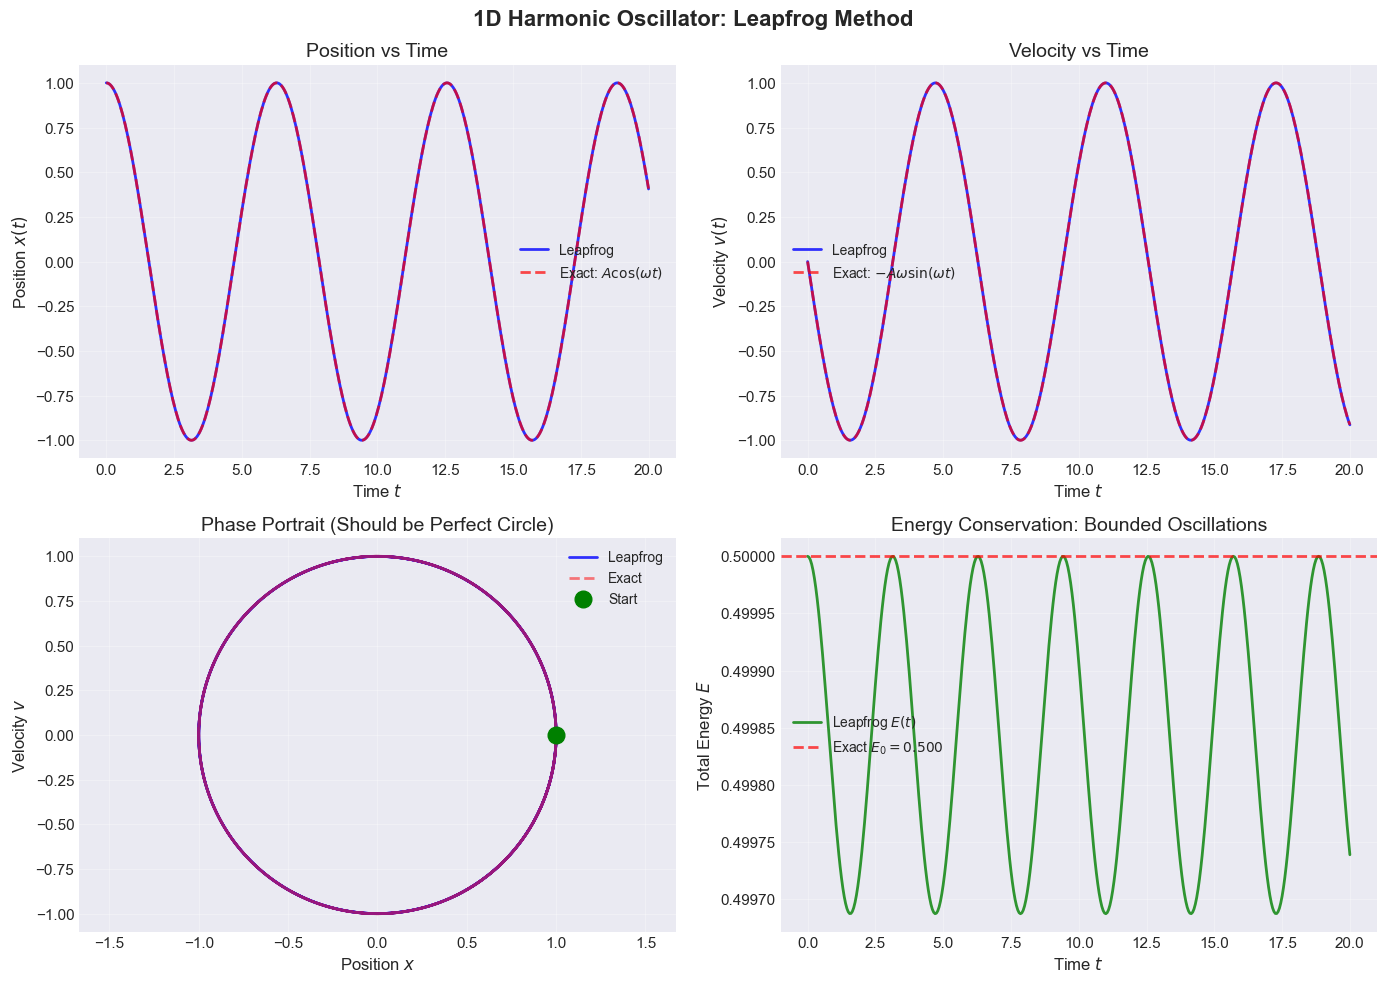


📊 Key Observations:
  1. Leapfrog follows exact solution very closely
  2. Phase portrait is nearly a perfect circle (energy conserved)
  3. Energy oscillates around true value with amplitude O(dt²)
  4. NO DRIFT over 3+ periods!

  → This is the POWER of symplectic integrators!


In [3]:
# Visualize harmonic oscillator

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('1D Harmonic Oscillator: Leapfrog Method', fontsize=16, fontweight='bold')

# Position vs time
ax = axes[0, 0]
ax.plot(t, x, 'b-', linewidth=2, label='Leapfrog', alpha=0.8)
ax.plot(t, x_exact, 'r--', linewidth=2, label='Exact: $A\cos(\omega t)$', alpha=0.7)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Position $x(t)$')
ax.set_title('Position vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity vs time
ax = axes[0, 1]
ax.plot(t, v, 'b-', linewidth=2, label='Leapfrog', alpha=0.8)
ax.plot(t, v_exact, 'r--', linewidth=2, label='Exact: $-A\omega\sin(\omega t)$', alpha=0.7)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Velocity $v(t)$')
ax.set_title('Velocity vs Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Phase portrait
ax = axes[1, 0]
ax.plot(x, v, 'b-', linewidth=2, label='Leapfrog', alpha=0.8)
ax.plot(x_exact, v_exact, 'r--', linewidth=2, label='Exact', alpha=0.5)
ax.plot(x[0], v[0], 'go', markersize=12, label='Start', zorder=5)
ax.set_xlabel('Position $x$')
ax.set_ylabel('Velocity $v$')
ax.set_title('Phase Portrait (Should be Perfect Circle)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Energy conservation
ax = axes[1, 1]
ax.plot(t, E_leapfrog, 'g-', linewidth=2, label='Leapfrog $E(t)$', alpha=0.8)
ax.axhline(y=E_exact, color='r', linestyle='--', linewidth=2, label=f'Exact $E_0 = {E_exact:.3f}$', alpha=0.7)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Total Energy $E$')
ax.set_title('Energy Conservation: Bounded Oscillations')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  1. Leapfrog follows exact solution very closely")
print("  2. Phase portrait is nearly a perfect circle (energy conserved)")
print("  3. Energy oscillates around true value with amplitude O(dt²)")
print("  4. NO DRIFT over 3+ periods!")
print("\n  → This is the POWER of symplectic integrators!")

# Part 2: General Solver Implementations

Now let's implement general-purpose solvers for both RK4 and Verlet.

---

In [4]:
# General RK4 and Verlet solvers

def rk4_step(state, t, dt, derivs_func):
    """
    Single RK4 step for system dy/dt = f(y, t).
    
    Parameters:
    -----------
    state : array
        Current state vector y_n
    t : float
        Current time
    dt : float
        Time step
    derivs_func : callable
        Returns derivatives: dy/dt = derivs_func(y, t)
    
    Returns:
    --------
    new_state : array
        State at t + dt
    """
    k1 = derivs_func(state, t)
    k2 = derivs_func(state + 0.5 * dt * k1, t + 0.5 * dt)
    k3 = derivs_func(state + 0.5 * dt * k2, t + 0.5 * dt)
    k4 = derivs_func(state + dt * k3, t + dt)
    
    return state + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)


def rk4_solve(state0, t_span, dt, derivs_func):
    """
    Solve ODE system using RK4.
    
    Parameters:
    -----------
    state0 : array
        Initial state
    t_span : tuple
        (t_start, t_end)
    dt : float
        Time step
    derivs_func : callable
        Derivatives function: dy/dt = derivs_func(y, t)
    
    Returns:
    --------
    times : array
        Time points
    states : array
        States at each time, shape (n_steps+1, n_dims)
    """
    t_start, t_end = t_span
    n_steps = int((t_end - t_start) / dt)

    times = np.linspace(t_start, t_end, n_steps + 1)
    states = np.zeros((n_steps + 1, len(state0)))
    states[0] = state0

    for i in range(n_steps):
        states[i + 1] = rk4_step(states[i], times[i], dt, derivs_func)

    return times, states


def verlet_step(x, v, dt, accel_func):
    """
    Single Verlet (Leapfrog) step for d²x/dt² = a(x).
    
    Kick-Drift-Kick algorithm.
    
    Parameters:
    -----------
    x : array
        Current positions
    v : array
        Current velocities
    dt : float
        Time step
    accel_func : callable
        Returns acceleration: a = accel_func(x)
    
    Returns:
    --------
    x_new : array
        Updated positions
    v_new : array
        Updated velocities
    """
    a = accel_func(x)
    v_half = v + 0.5 * a * dt
    x_new = x + v_half * dt
    a_new = accel_func(x_new)
    v_new = v_half + 0.5 * a_new * dt
    
    return x_new, v_new


def verlet_solve(x0, v0, t_span, dt, accel_func):
    """
    Solve d²x/dt² = a(x) using Verlet method.
    
    Parameters:
    -----------
    x0 : array
        Initial positions
    v0 : array
        Initial velocities
    t_span : tuple
        (t_start, t_end)
    dt : float
        Time step
    accel_func : callable
        Acceleration function: a = accel_func(x)
    
    Returns:
    --------
    times : array
        Time points
    positions : array
        Positions at each time
    velocities : array
        Velocities at each time
    """
    t_start, t_end = t_span
    n_steps = int((t_end - t_start) / dt)

    times = np.linspace(t_start, t_end, n_steps + 1)
    positions = np.zeros((n_steps + 1, len(x0)))
    velocities = np.zeros((n_steps + 1, len(x0)))

    positions[0] = x0
    velocities[0] = v0

    x, v = x0.copy(), v0.copy()
    for i in range(n_steps):
        x, v = verlet_step(x, v, dt, accel_func)
        positions[i + 1] = x
        velocities[i + 1] = v

    return times, positions, velocities


print("✓ Generic RK4 and Verlet solvers implemented")
print("  - rk4_solve: For general ODE systems dy/dt = f(y,t)")
print("  - verlet_solve: For Hamiltonian systems d²x/dt² = a(x)")

✓ Generic RK4 and Verlet solvers implemented
  - rk4_solve: For general ODE systems dy/dt = f(y,t)
  - verlet_solve: For Hamiltonian systems d²x/dt² = a(x)


# Part 3: Demonstration Problems

We'll explore three systems that illustrate different behaviors:

1. **Damped Driven Pendulum** - Non-conservative (energy not conserved)
2. **Coupled Spring-Mass System** - Conservative (similar to homework)
3. **Van der Pol Oscillator** - Self-sustained limit cycle

---

## Problem 1: Damped Driven Pendulum

### Equation of Motion

$$\ddot{\theta} + 2\gamma\dot{\theta} + \omega_0^2\sin(\theta) = A\cos(\omega_d t)$$

where:
- $\theta$: angular displacement from vertical
- $\gamma$: damping coefficient
- $\omega_0 = \sqrt{g/L}$: natural frequency
- $A$: driving amplitude
- $\omega_d$: driving frequency

### Physical Terms

1. $-\omega_0^2\sin(\theta)$: Restoring torque from gravity
2. $-2\gamma\dot{\theta}$: Damping (energy dissipation)
3. $A\cos(\omega_d t)$: External driving force (energy injection)

### Why This Problem?

**Different from homework:**
- **Non-conservative**: Energy flows in (driving) and out (damping)
- **Velocity-dependent damping**: $F \propto \dot{\theta}$
- **Time-dependent forcing**: Explicit $t$ dependence

**Key learning:**
- Verlet **cannot handle** this problem (velocity-dependent force)
- Must use RK4 or similar general-purpose method
- Energy is not conserved (by design)

### First-Order Form

Let $\omega = \dot{\theta}$:

$$\begin{cases}
\dot{\theta} = \omega \\
\dot{\omega} = -2\gamma\omega - \omega_0^2\sin(\theta) + A\cos(\omega_d t)
\end{cases}$$

State vector: $\vec{y} = [\theta, \omega]^T$

### Energy (Mechanical)

$$E_{mech} = \underbrace{\frac{1}{2}I\omega^2}_{\text{kinetic}} + \underbrace{mgl(1 - \cos\theta)}_{\text{potential}}$$

With $I = ml^2$ and measuring energy per unit $ml^2$:

$$E = \frac{1}{2}\omega^2 + \omega_0^2(1 - \cos\theta)$$

**Note:** This is NOT conserved! Damping removes energy, driving adds it.

---

In [5]:
# Problem 1: Damped Driven Pendulum

def pendulum_derivs(state, t, gamma=0.5, omega0=1.0, A=1.2, omega_d=0.667):
    """
    Derivatives for damped driven pendulum.
    
    Equation: θ'' + 2γθ' + ω₀²sin(θ) = A*cos(ω_d*t)
    
    State: [theta, omega] where omega = dtheta/dt
    
    Returns: [dtheta/dt, domega/dt]
    """
    theta, omega = state

    dtheta_dt = omega
    domega_dt = -2 * gamma * omega - omega0**2 * np.sin(theta) + A * np.cos(omega_d * t)

    return np.array([dtheta_dt, domega_dt])


def pendulum_energy(theta, omega, omega0=1.0):
    """
    Mechanical energy (without driving term).
    
    E = (1/2)*omega^2 + omega0^2*(1 - cos(theta))
    
    Note: This is NOT conserved due to damping and driving!
    """
    kinetic = 0.5 * omega**2
    potential = omega0**2 * (1 - np.cos(theta))

    return kinetic + potential


print("="*70)
print("Problem 1: Damped Driven Pendulum")
print("="*70)

# Initial conditions
theta0 = 0.2  # Small angle (radians)
omega0_init = 0.0  # Start from rest
state0 = np.array([theta0, omega0_init])

# Parameters
gamma = 0.5
omega0 = 1.0
A = 1.2
omega_d = 0.667

# Solve with RK4
dt = 0.01
t_span = (0, 100)

t_pend, states_pend = rk4_solve(
    state0, t_span, dt, 
    lambda s, t: pendulum_derivs(s, t, gamma, omega0, A, omega_d)
)

theta_pend = states_pend[:, 0]
omega_pend = states_pend[:, 1]
energy_pend = pendulum_energy(theta_pend, omega_pend, omega0)

print(f"\nParameters:")
print(f"  Damping: γ = {gamma}")
print(f"  Natural frequency: ω₀ = {omega0}")
print(f"  Driving amplitude: A = {A}")
print(f"  Driving frequency: ω_d = {omega_d}")
print(f"  Time step: dt = {dt}")
print(f"  Duration: T = {t_span[1]}")

print(f"\nInitial conditions:")
print(f"  θ(0) = {theta0} rad = {np.degrees(theta0):.1f}°")
print(f"  ω(0) = {omega0_init} rad/s")

print(f"\nResults:")
print(f"  Energy at t=0: {energy_pend[0]:.4f}")
print(f"  Energy at t={t_span[1]}: {energy_pend[-1]:.4f}")
print(f"  Energy change: {energy_pend[-1] - energy_pend[0]:.4f}")
print(f"\n✓ Solved with RK4 (Verlet would fail!)")
print(f"✓ Energy is NOT conserved (as expected)")

Problem 1: Damped Driven Pendulum

Parameters:
  Damping: γ = 0.5
  Natural frequency: ω₀ = 1.0
  Driving amplitude: A = 1.2
  Driving frequency: ω_d = 0.667
  Time step: dt = 0.01
  Duration: T = 100

Initial conditions:
  θ(0) = 0.2 rad = 11.5°
  ω(0) = 0.0 rad/s

Results:
  Energy at t=0: 0.0199
  Energy at t=100: 0.9963
  Energy change: 0.9764

✓ Solved with RK4 (Verlet would fail!)
✓ Energy is NOT conserved (as expected)


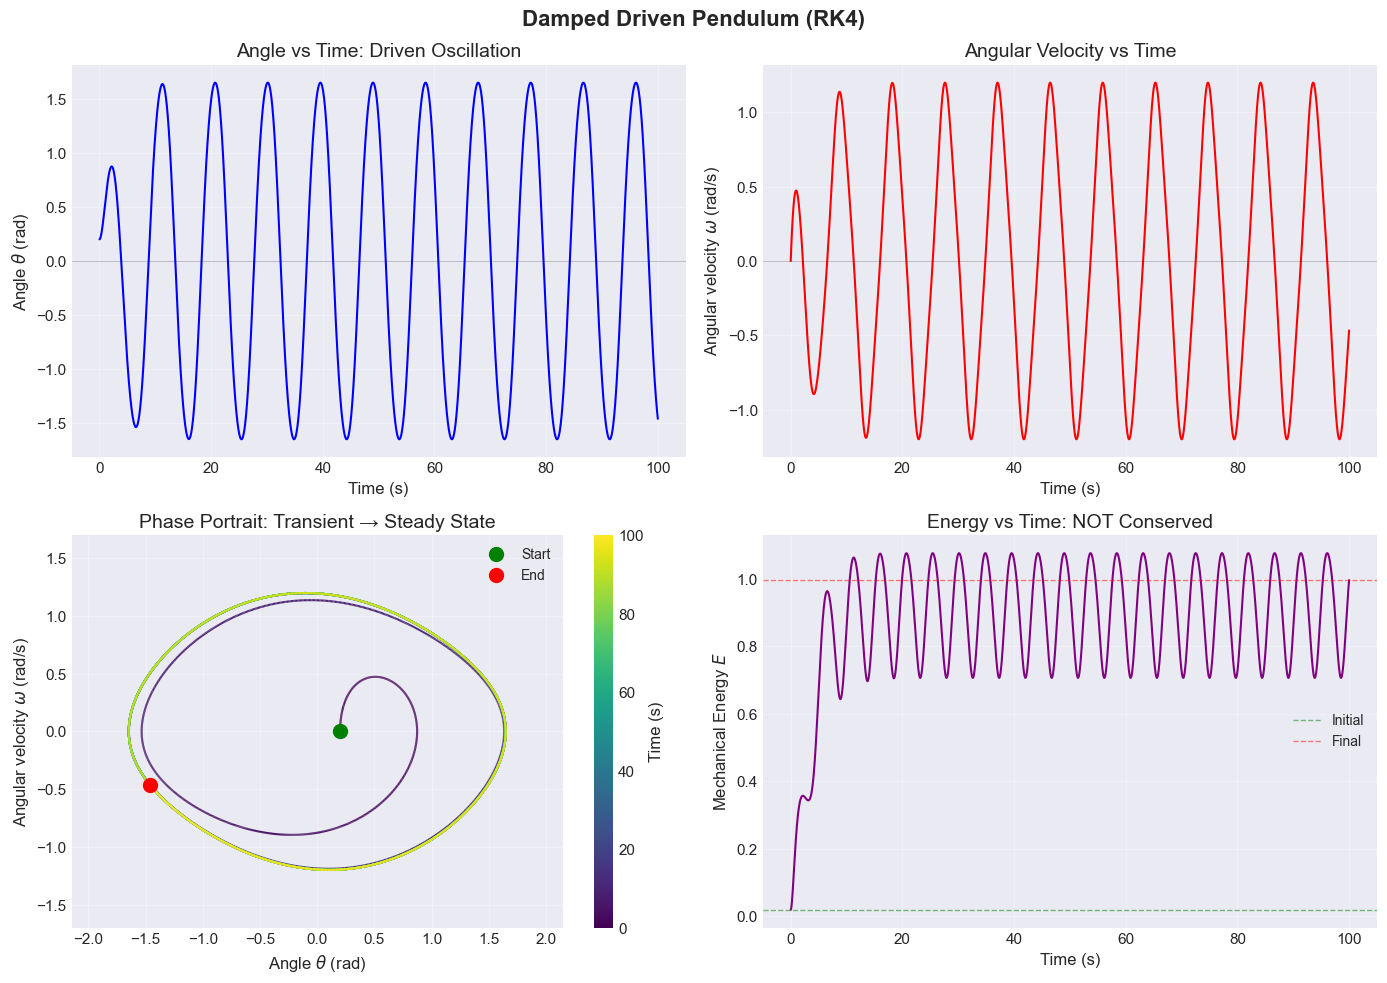


📊 Observations:
  1. System reaches steady-state oscillation after transient
  2. Phase portrait shows spiral toward periodic attractor
  3. Energy oscillates as driving adds/removes energy
  4. RK4 handles this correctly; Verlet cannot (velocity-dependent damping)

  → Lesson: Use RK4 for non-conservative systems!


In [6]:
# Visualize damped driven pendulum

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Damped Driven Pendulum (RK4)', fontsize=16, fontweight='bold')

# Angle vs time
ax = axes[0, 0]
ax.plot(t_pend, theta_pend, 'b-', linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angle $\\theta$ (rad)')
ax.set_title('Angle vs Time: Driven Oscillation')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Angular velocity vs time
ax = axes[0, 1]
ax.plot(t_pend, omega_pend, 'r-', linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Angular velocity $\\omega$ (rad/s)')
ax.set_title('Angular Velocity vs Time')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

# Phase portrait
ax = axes[1, 0]
# Plot with color gradient showing time evolution
points = np.array([theta_pend, omega_pend]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
from matplotlib.collections import LineCollection
lc = LineCollection(segments, cmap='viridis', linewidth=1.5)
lc.set_array(t_pend)
line = ax.add_collection(lc)
ax.plot(theta_pend[0], omega_pend[0], 'go', markersize=10, label='Start', zorder=5)
ax.plot(theta_pend[-1], omega_pend[-1], 'ro', markersize=10, label='End', zorder=5)
ax.set_xlabel('Angle $\\theta$ (rad)')
ax.set_ylabel('Angular velocity $\\omega$ (rad/s)')
ax.set_title('Phase Portrait: Transient → Steady State')
ax.legend()
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(line, ax=ax)
cbar.set_label('Time (s)')
ax.set_xlim([theta_pend.min()-0.5, theta_pend.max()+0.5])
ax.set_ylim([omega_pend.min()-0.5, omega_pend.max()+0.5])

# Energy vs time
ax = axes[1, 1]
ax.plot(t_pend, energy_pend, 'purple', linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Mechanical Energy $E$')
ax.set_title('Energy vs Time: NOT Conserved')
ax.grid(True, alpha=0.3)
# Add horizontal lines for reference
ax.axhline(y=energy_pend[0], color='g', linestyle='--', linewidth=1, alpha=0.5, label='Initial')
ax.axhline(y=energy_pend[-1], color='r', linestyle='--', linewidth=1, alpha=0.5, label='Final')
ax.legend()

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  1. System reaches steady-state oscillation after transient")
print("  2. Phase portrait shows spiral toward periodic attractor")
print("  3. Energy oscillates as driving adds/removes energy")
print("  4. RK4 handles this correctly; Verlet cannot (velocity-dependent damping)")
print("\n  → Lesson: Use RK4 for non-conservative systems!")

### Why Verlet Fails for This Problem

The damping term $-2\gamma\dot{\theta}$ creates a problem for Verlet:

**Verlet assumption:** $\ddot{x} = a(x)$ (acceleration depends only on position)

**This problem:** $\ddot{\theta} = a(\theta, \dot{\theta}, t)$ (depends on position, velocity, AND time)

**What goes wrong:**

In the Leapfrog algorithm:
1. Compute $a_n = a(\theta_n, \omega_n, t_n)$ ✓
2. Update $\omega_{n+1/2} = \omega_n + \frac{h}{2}a_n$ ✓
3. Update $\theta_{n+1} = \theta_n + h\omega_{n+1/2}$ ✓
4. Compute $a_{n+1} = a(\theta_{n+1}, \omega_{n+1}, t_{n+1})$ ✗

**Problem:** At step 4, we don't have $\omega_{n+1}$ yet! We only have $\omega_{n+1/2}$.

This creates an **implicit equation** that defeats the simplicity of Verlet.

---

## Problem 2: Coupled Spring-Mass System

### Physical Setup

Two masses connected by a spring:

```
  Wall ~~~[spring]~~~ m₁ ~~~[spring]~~~ m₂ ~~~[spring]~~~ Wall
```

### Equations of Motion

$$m_1\ddot{x}_1 = -k(x_1 - x_2)$$
$$m_2\ddot{x}_2 = -k(x_2 - x_1)$$

For simplicity: $m_1 = m_2 = 1$, $k = 1$

$$\ddot{x}_1 = -(x_1 - x_2) = x_2 - x_1$$
$$\ddot{x}_2 = -(x_2 - x_1) = x_1 - x_2$$

### Why This Problem?

**Similar to homework:**
- **Conservative system**: Energy conserved
- **Coupled equations**: Two particles interact
- **4D phase space**: $(x_1, x_2, v_1, v_2)$ (your homework is 8D)

**Different from homework:**
- **Linear forces**: Easier to analyze
- **Oscillatory motion**: Not orbital
- **Normal modes**: Special eigenvector solutions

**Key learning:**
- Both RK4 and Verlet work
- Verlet preserves energy better
- Direct analogy to homework structure

### First-Order Form (for RK4)

State: $\vec{y} = [x_1, x_2, v_1, v_2]^T$

$$\frac{d\vec{y}}{dt} = \begin{bmatrix}
v_1 \\
v_2 \\
x_2 - x_1 \\
x_1 - x_2
\end{bmatrix}$$

### Acceleration Form (for Verlet)

Positions: $\vec{x} = [x_1, x_2]^T$

Velocities: $\vec{v} = [v_1, v_2]^T$

Accelerations: $\vec{a}(\vec{x}) = \begin{bmatrix}
x_2 - x_1 \\
x_1 - x_2
\end{bmatrix}$

### Total Energy

$$E = \underbrace{\frac{1}{2}m_1 v_1^2 + \frac{1}{2}m_2 v_2^2}_{\text{kinetic}} + \underbrace{\frac{1}{2}k(x_1 - x_2)^2}_{\text{potential}}$$

With $m_1 = m_2 = k = 1$:

$$\boxed{E = \frac{1}{2}(v_1^2 + v_2^2) + \frac{1}{2}(x_1 - x_2)^2}$$

This **should be conserved**! (no damping, no driving)

### Normal Modes

**Symmetric mode:** $x_1 = x_2$ (both move together)
- Frequency: $\omega_{sym} = 0$ (center-of-mass motion)

**Antisymmetric mode:** $x_1 = -x_2$ (stretch/compress spring)
- Frequency: $\omega_{anti} = \sqrt{2k/m} = \sqrt{2}$

---

In [7]:
# Problem 2: Coupled Spring-Mass System

def coupled_springs_derivs(state, t, k=1.0, m1=1.0, m2=1.0):
    """
    Derivatives for coupled spring-mass system.
    
    State: [x1, x2, v1, v2]
    
    Equations:
      dx1/dt = v1
      dx2/dt = v2
      dv1/dt = -(k/m1)*(x1 - x2)
      dv2/dt = -(k/m2)*(x2 - x1)
    """
    x1, x2, v1, v2 = state
    dx1_dt = v1
    dx2_dt = v2
    dv1_dt = -(k/m1)*(x1 - x2)
    dv2_dt = -(k/m2)*(x2 - x1)

    return np.array([dx1_dt, dx2_dt, dv1_dt, dv2_dt])

def coupled_springs_accel(x, k=1.0, m1=1.0, m2=1.0):
    """
    Acceleration for Verlet method.
    
    x: [x1, x2] positions
    Returns: [a1, a2] accelerations
    """
    x1, x2 = x
    a1 = -(k/m1)*(x1 - x2)
    a2 = -(k/m2)*(x2 - x1)

    return np.array([a1, a2])


def springs_energy(x1, x2, v1, v2, k=1.0, m1=1.0, m2=1.0):
    """
    Total energy: kinetic + potential.
    
    E = (1/2)*m1*v1² + (1/2)*m2*v2² + (1/2)*k*(x1-x2)²
    
    This SHOULD be conserved!
    """
    kinetic = 0.5*m1 * v1**2 + 0.5*m2 * v2**2
    potential = 0.5*k*(x1 - x2)**2

    return kinetic + potential


print("="*70)
print("Problem 2: Coupled Spring-Mass System")
print("="*70)

# Initial conditions: displace first mass, second at equilibrium
x1_0, x2_0 = 1.0, 0.0  # Positions
v1_0, v2_0 = 0.0, 0.0  # Velocities (start from rest)

state0_springs = np.array([x1_0, x2_0, v1_0, v2_0])
pos0_springs = np.array([x1_0, x2_0])
vel0_springs = np.array([v1_0, v2_0])

# Solve with both methods
dt = 0.1
t_span = (0, 20000)

print(f"\nInitial conditions:")
print(f"  x₁(0) = {x1_0}, v₁(0) = {v1_0}")
print(f"  x₂(0) = {x2_0}, v₂(0) = {v2_0}")
print(f"  (Antisymmetric mode: stretch spring, both at rest)")

# RK4
print(f"\nSolving with RK4...")
t_springs_rk4, states_springs_rk4 = rk4_solve(
    state0_springs, t_span, dt, coupled_springs_derivs
)
x1_rk4 = states_springs_rk4[:, 0]
x2_rk4 = states_springs_rk4[:, 1]
v1_rk4 = states_springs_rk4[:, 2]
v2_rk4 = states_springs_rk4[:, 3]
energy_springs_rk4 = springs_energy(x1_rk4, x2_rk4, v1_rk4, v2_rk4)

# Verlet
print(f"Solving with Verlet...")
t_springs_verlet, pos_springs_verlet, vel_springs_verlet = verlet_solve(
    pos0_springs, vel0_springs, t_span, dt, coupled_springs_accel
)
x1_verlet = pos_springs_verlet[:, 0]
x2_verlet = pos_springs_verlet[:, 1]
v1_verlet = vel_springs_verlet[:, 0]
v2_verlet = vel_springs_verlet[:, 1]
energy_springs_verlet = springs_energy(x1_verlet, x2_verlet, v1_verlet, v2_verlet)

# Energy statistics
E0_rk4 = energy_springs_rk4[0]
E0_verlet = energy_springs_verlet[0]
rel_error_rk4 = np.abs(energy_springs_rk4 - E0_rk4) / E0_rk4
rel_error_verlet = np.abs(energy_springs_verlet - E0_verlet) / E0_verlet

print(f"\n✓ Both methods completed")
print(f"\nEnergy Conservation:")
print(f"  Initial energy: E₀ = {E0_rk4:.6f}")
print(f"\n  RK4:")
print(f"    Max relative error: {rel_error_rk4.max():.2e}")
print(f"    Final relative error: {rel_error_rk4[-1]:.2e}")
print(f"\n  Verlet:")
print(f"    Max relative error: {rel_error_verlet.max():.2e}")
print(f"    Final relative error: {rel_error_verlet[-1]:.2e}")
print(f"\n  → Verlet preserves energy {rel_error_rk4[-1]/rel_error_verlet[-1]:.0f}x better!")

Problem 2: Coupled Spring-Mass System

Initial conditions:
  x₁(0) = 1.0, v₁(0) = 0.0
  x₂(0) = 0.0, v₂(0) = 0.0
  (Antisymmetric mode: stretch spring, both at rest)

Solving with RK4...
Solving with Verlet...

✓ Both methods completed

Energy Conservation:
  Initial energy: E₀ = 0.500000

  RK4:
    Max relative error: 2.19e-02
    Final relative error: 2.19e-02

  Verlet:
    Max relative error: 5.00e-03
    Final relative error: 3.53e-03

  → Verlet preserves energy 6x better!


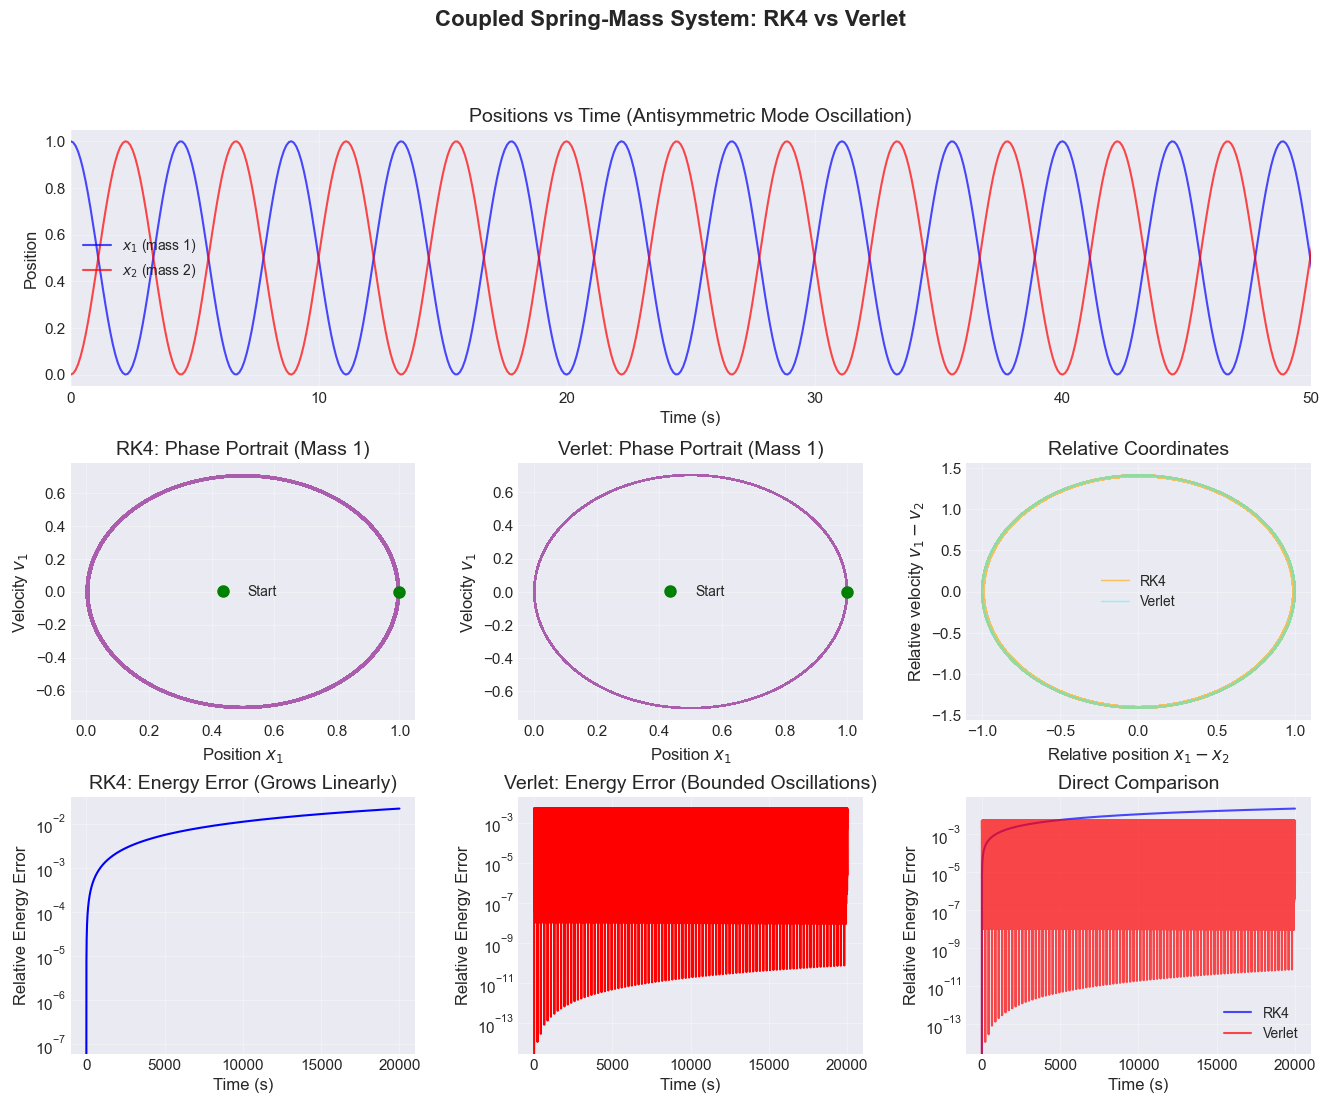


📊 Key Observations:
  1. Both methods give correct oscillations
  2. Phase portraits are closed orbits (energy conserved)
  3. RK4 energy error grows linearly with time
  4. Verlet energy error is bounded (oscillates but doesn't drift)
  5. For long simulations, Verlet is MUCH better!

  → Lesson: For conservative systems, use Verlet!


In [8]:
# Visualize coupled springs: RK4 vs Verlet comparison

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Coupled Spring-Mass System: RK4 vs Verlet', fontsize=16, fontweight='bold')

# Row 1: Time series
ax = fig.add_subplot(gs[0, :])
ax.plot(t_springs_rk4, x1_rk4, 'b-', label='$x_1$ (mass 1)', linewidth=1.5, alpha=0.7)
ax.plot(t_springs_rk4, x2_rk4, 'r-', label='$x_2$ (mass 2)', linewidth=1.5, alpha=0.7)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position')
ax.set_title('Positions vs Time (Antisymmetric Mode Oscillation)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 50])  # Show first 50 seconds

# Row 2: Phase portraits
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(x1_rk4, v1_rk4, 'purple', linewidth=1, alpha=0.6)
ax1.plot(x1_rk4[0], v1_rk4[0], 'go', markersize=8, label='Start')
ax1.set_xlabel('Position $x_1$')
ax1.set_ylabel('Velocity $v_1$')
ax1.set_title('RK4: Phase Portrait (Mass 1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(x1_verlet, v1_verlet, 'purple', linewidth=1, alpha=0.6)
ax2.plot(x1_verlet[0], v1_verlet[0], 'go', markersize=8, label='Start')
ax2.set_xlabel('Position $x_1$')
ax2.set_ylabel('Velocity $v_1$')
ax2.set_title('Verlet: Phase Portrait (Mass 1)')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(x1_rk4 - x2_rk4, v1_rk4 - v2_rk4, 'orange', linewidth=1, alpha=0.6, label='RK4')
ax3.plot(x1_verlet - x2_verlet, v1_verlet - v2_verlet, 'cyan', linewidth=1, alpha=0.4, label='Verlet')
ax3.set_xlabel('Relative position $x_1 - x_2$')
ax3.set_ylabel('Relative velocity $v_1 - v_2$')
ax3.set_title('Relative Coordinates')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 3: Energy conservation
ax4 = fig.add_subplot(gs[2, 0])
ax4.semilogy(t_springs_rk4, rel_error_rk4, 'b-', linewidth=1.5)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Relative Energy Error')
ax4.set_title('RK4: Energy Error (Grows Linearly)')
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[2, 1])
ax5.semilogy(t_springs_verlet, rel_error_verlet, 'r-', linewidth=1.5)
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Relative Energy Error')
ax5.set_title('Verlet: Energy Error (Bounded Oscillations)')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 2])
ax6.semilogy(t_springs_rk4, rel_error_rk4, 'b-', linewidth=1.5, label='RK4', alpha=0.7)
ax6.semilogy(t_springs_verlet, rel_error_verlet, 'r-', linewidth=1.5, label='Verlet', alpha=0.7)
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Relative Energy Error')
ax6.set_title('Direct Comparison')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.show()

print("\n📊 Key Observations:")
print("  1. Both methods give correct oscillations")
print("  2. Phase portraits are closed orbits (energy conserved)")
print("  3. RK4 energy error grows linearly with time")
print("  4. Verlet energy error is bounded (oscillates but doesn't drift)")
print("  5. For long simulations, Verlet is MUCH better!")
print("\n  → Lesson: For conservative systems, use Verlet!")

### Connection to Your Homework

Your homework problem is structurally identical:

| Coupled Springs | Your Homework |
|-----------------|---------------|
| 2 particles | 2 particles |
| 1D motion each → 4D state | 2D motion each → 8D state |
| $\ddot{x}_i = f(x_1, x_2)$ | $\ddot{\vec{x}} = \vec{F}(\vec{x}, \vec{y})$ |
| Linear forces | Nonlinear (1/r²) forces |
| Energy conserved | Energy conserved |

---

## Problem 3: Van der Pol Oscillator

### Equation of Motion

$$\ddot{x} - \mu(1 - x^2)\dot{x} + x = 0$$

where $\mu > 0$ is the nonlinearity parameter.

### Physical Interpretation

Rewrite as:
$$\ddot{x} + x = \mu(1 - x^2)\dot{x}$$

**Left side:** Simple harmonic oscillator

**Right side:** **Nonlinear damping**
- When $|x| < 1$: $1 - x^2 > 0$ → **Negative damping** (adds energy)
- When $|x| > 1$: $1 - x^2 < 0$ → **Positive damping** (removes energy)

Result: System self-regulates to maintain oscillations at $|x| \approx 1$!

### Why This Problem?

**Different from homework:**
- **Self-sustained oscillations**: Limit cycle, not closed orbits
- **Nonlinear damping**: Amplitude-dependent
- **Attractor**: All initial conditions → same periodic orbit

**Key learning:**
- Not all oscillators conserve energy
- Limit cycles vs closed orbits
- RK4 essential (Verlet fails: velocity-dependent)

### First-Order Form

Let $v = \dot{x}$:

$$\begin{cases}
\dot{x} = v \\
\dot{v} = \mu(1 - x^2)v - x
\end{cases}$$

### "Energy" (Not Conserved!)

We can define an energy-like quantity:

$$E = \frac{1}{2}v^2 + \frac{1}{2}x^2$$

But this is NOT conserved:

$$\frac{dE}{dt} = v\dot{v} + x\dot{x} = v[\mu(1-x^2)v - x] + xv = \mu(1-x^2)v^2$$

- When $|x| < 1$ and $v \neq 0$: $\frac{dE}{dt} > 0$ (energy increases)
- When $|x| > 1$ and $v \neq 0$: $\frac{dE}{dt} < 0$ (energy decreases)

---

In [9]:
# Problem 3: Van der Pol Oscillator

def van_der_pol_derivs(state, t, mu=1.0):
    """
    Derivatives for Van der Pol oscillator.
    
    Equation: ẍ - μ(1 - x²)ẋ + x = 0
    
    State: [x, v] where v = dx/dt
    
    Returns: [dx/dt, dv/dt]
    """
    x, v = state
    dx_dt = v
    dv_dt = mu * (1 - x**2) * v - x
    
    return np.array([dx_dt, dv_dt])


def van_der_pol_energy(x, v):
    """
    "Energy-like" quantity (NOT conserved!).
    
    E = (1/2)*v² + (1/2)*x²
    """
    return 0.5 * v**2 + 0.5 * x**2


print("="*70)
print("Problem 3: Van der Pol Oscillator")
print("="*70)

# Solve for three different initial conditions
mu = 1.0
dt = 0.01
t_span = (0, 50)

ic1 = np.array([0.1, 0.1])   # Small amplitude
ic2 = np.array([3.0, 3.0])   # Large amplitude
ic3 = np.array([-2.0, 1.0])  # Different quadrant

print(f"\nParameters:")
print(f"  μ = {mu}")
print(f"  Time step: dt = {dt}")
print(f"  Duration: T = {t_span[1]}")

print(f"\nSolving for three initial conditions:")
print(f"  IC1: (x, v) = {ic1}  [small amplitude]")
print(f"  IC2: (x, v) = {ic2}  [large amplitude]")
print(f"  IC3: (x, v) = {ic3}  [different quadrant]")

t_vdp1, states_vdp1 = rk4_solve(ic1, t_span, dt, lambda s, t: van_der_pol_derivs(s, t, mu))
t_vdp2, states_vdp2 = rk4_solve(ic2, t_span, dt, lambda s, t: van_der_pol_derivs(s, t, mu))
t_vdp3, states_vdp3 = rk4_solve(ic3, t_span, dt, lambda s, t: van_der_pol_derivs(s, t, mu))

print(f"\n✓ All trajectories computed")
print(f"\nExpected behavior:")
print(f"  - Small IC: grows to limit cycle")
print(f"  - Large IC: shrinks to limit cycle")
print(f"  - All converge to SAME periodic orbit!")

Problem 3: Van der Pol Oscillator

Parameters:
  μ = 1.0
  Time step: dt = 0.01
  Duration: T = 50

Solving for three initial conditions:
  IC1: (x, v) = [0.1 0.1]  [small amplitude]
  IC2: (x, v) = [3. 3.]  [large amplitude]
  IC3: (x, v) = [-2.  1.]  [different quadrant]

✓ All trajectories computed

Expected behavior:
  - Small IC: grows to limit cycle
  - Large IC: shrinks to limit cycle
  - All converge to SAME periodic orbit!


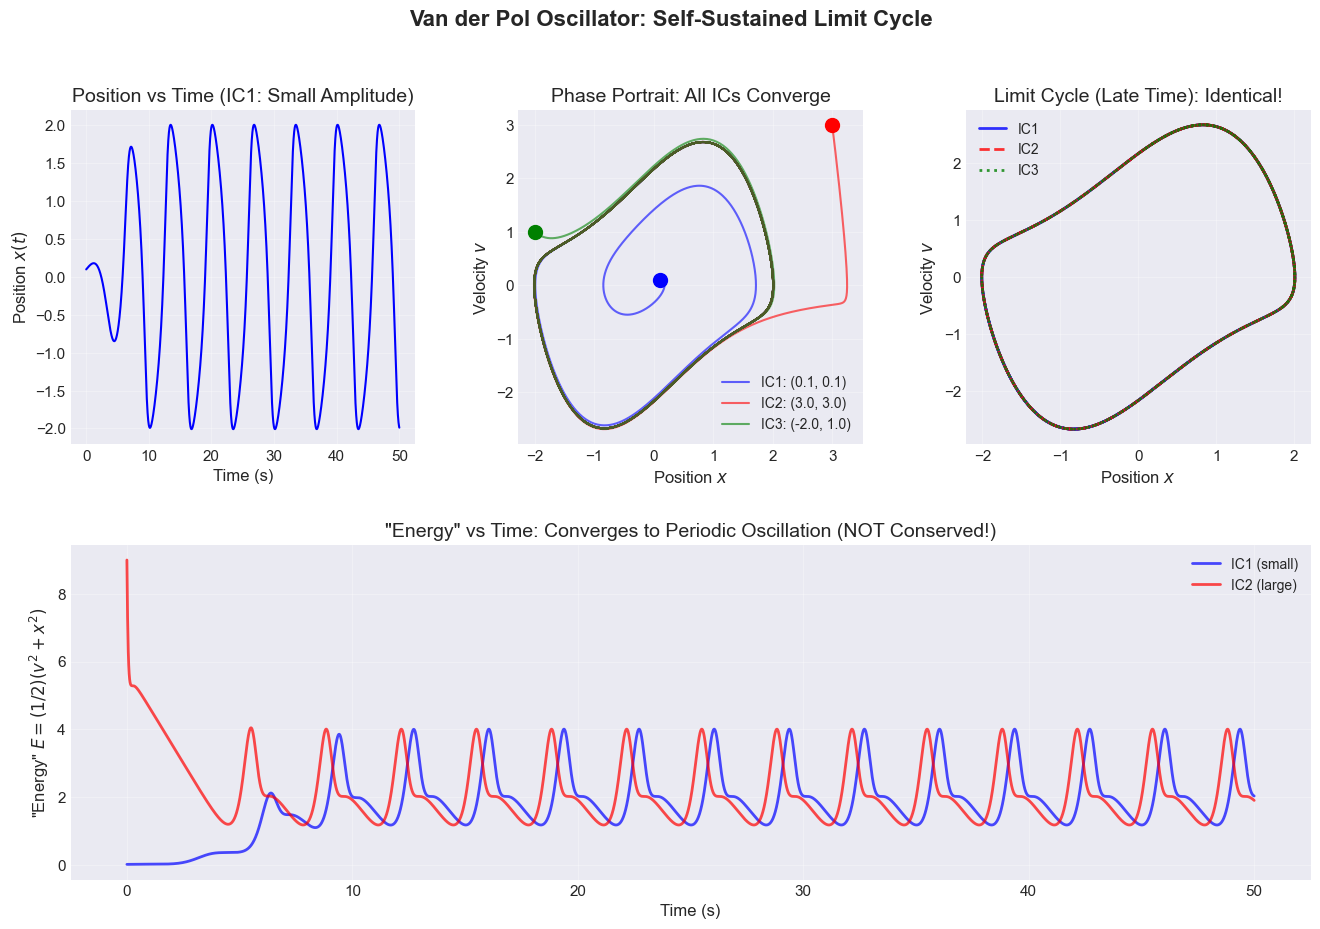


📊 Observations:
  1. All initial conditions converge to SAME limit cycle
  2. Small oscillations grow (negative damping)
  3. Large oscillations shrink (positive damping)
  4. Limit cycle is STABLE attractor
  5. 'Energy' settles to periodic oscillation (not constant)

  → Lesson: Not all oscillators conserve energy!
  → Verlet would fail (velocity-dependent force)


In [10]:
# Visualize Van der Pol oscillator

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
fig.suptitle('Van der Pol Oscillator: Self-Sustained Limit Cycle', fontsize=16, fontweight='bold')

# Time series for IC1
ax = fig.add_subplot(gs[0, 0])
ax.plot(t_vdp1, states_vdp1[:, 0], 'b-', linewidth=1.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Position $x(t)$')
ax.set_title('Position vs Time (IC1: Small Amplitude)')
ax.grid(True, alpha=0.3)

# Full phase portrait: All ICs
ax = fig.add_subplot(gs[0, 1])
ax.plot(states_vdp1[:, 0], states_vdp1[:, 1], 'b-', linewidth=1.5, alpha=0.6, label='IC1: (0.1, 0.1)')
ax.plot(states_vdp2[:, 0], states_vdp2[:, 1], 'r-', linewidth=1.5, alpha=0.6, label='IC2: (3.0, 3.0)')
ax.plot(states_vdp3[:, 0], states_vdp3[:, 1], 'g-', linewidth=1.5, alpha=0.6, label='IC3: (-2.0, 1.0)')
# Mark starting points
ax.plot(ic1[0], ic1[1], 'bo', markersize=10, zorder=5)
ax.plot(ic2[0], ic2[1], 'ro', markersize=10, zorder=5)
ax.plot(ic3[0], ic3[1], 'go', markersize=10, zorder=5)
ax.set_xlabel('Position $x$')
ax.set_ylabel('Velocity $v$')
ax.set_title('Phase Portrait: All ICs Converge')
ax.legend()
ax.grid(True, alpha=0.3)

# Late-time phase portrait (limit cycle)
idx_late = int(0.7 * len(t_vdp1))  # Last 30% of simulation
ax = fig.add_subplot(gs[0, 2])
ax.plot(states_vdp1[idx_late:, 0], states_vdp1[idx_late:, 1], 'b-', 
        linewidth=2, alpha=0.8, label='IC1')
ax.plot(states_vdp2[idx_late:, 0], states_vdp2[idx_late:, 1], 'r--', 
        linewidth=2, alpha=0.8, label='IC2')
ax.plot(states_vdp3[idx_late:, 0], states_vdp3[idx_late:, 1], 'g:', 
        linewidth=2, alpha=0.8, label='IC3')
ax.set_xlabel('Position $x$')
ax.set_ylabel('Velocity $v$')
ax.set_title('Limit Cycle (Late Time): Identical!')
ax.legend()
ax.grid(True, alpha=0.3)

# "Energy" for IC1 and IC2
energy_vdp1 = van_der_pol_energy(states_vdp1[:, 0], states_vdp1[:, 1])
energy_vdp2 = van_der_pol_energy(states_vdp2[:, 0], states_vdp2[:, 1])

ax = fig.add_subplot(gs[1, :])
ax.plot(t_vdp1, energy_vdp1, 'b-', linewidth=2, label='IC1 (small)', alpha=0.7)
ax.plot(t_vdp2, energy_vdp2, 'r-', linewidth=2, label='IC2 (large)', alpha=0.7)
ax.set_xlabel('Time (s)')
ax.set_ylabel('"Energy" $E = (1/2)(v^2 + x^2)$')
ax.set_title('"Energy" vs Time: Converges to Periodic Oscillation (NOT Conserved!)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

print("\n📊 Observations:")
print("  1. All initial conditions converge to SAME limit cycle")
print("  2. Small oscillations grow (negative damping)")
print("  3. Large oscillations shrink (positive damping)")
print("  4. Limit cycle is STABLE attractor")
print("  5. 'Energy' settles to periodic oscillation (not constant)")
print("\n  → Lesson: Not all oscillators conserve energy!")
print("  → Verlet would fail (velocity-dependent force)")

### Limit Cycles vs Closed Orbits

**Hamiltonian systems (like your homework):**
- **Closed orbits**: Each initial condition gives different orbit
- **Continuous family**: Orbits nest inside each other
- **Energy conserved**: Each orbit has fixed energy
- **Example**: Planets, harmonic oscillators, your homework

**Dissipative systems with limit cycles (like Van der Pol):**
- **Single limit cycle**: All ICs converge to same orbit
- **Isolated orbit**: Doesn't belong to continuous family
- **Energy not conserved**: Oscillates periodically
- **Example**: Van der Pol, heart beats, circadian rhythms

---

# Part 4: Step Size Selection

## How to Choose Time Step $h$

### Error Estimates

**RK4:**
- Local error: $\epsilon_{local} \sim Ch^5$
- Global error: $\epsilon_{global} \sim \tilde{C}h^4$
- Energy drift: $\Delta E \sim D h^4 T$ (grows with time $T$)

**Verlet:**
- Local error: $\epsilon_{local} \sim Ch^3$
- Global error: $\epsilon_{global} \sim \tilde{C}h^2$
- Energy error: $\Delta E \sim D h^2$ (bounded, doesn't grow!)

### Strategy for Your Homework

Target: $\epsilon \sim 10^{-4}$

1. **Start with $h = 0.01$** (reasonable guess)
2. **Run simulation** and compute energy error
3. **If error too large:** Reduce $h$ by factor of 2
4. **If error too small:** Can increase $h$ (but be conservative)

### Adaptive Step Size (Advanced)

Compare two steps of size $h$ with one step of size $2h$:

$$\epsilon_{est} = \frac{|\vec{y}_{2h} - \vec{y}_{h+h}|}{2^p - 1}$$

where $p$ is the order (4 for RK4, 2 for Verlet).

Then adjust: $h_{new} = 0.9 h \left(\frac{\epsilon_{target}}{\epsilon_{est}}\right)^{1/p}$

---

Step Size Analysis: Energy Conservation vs dt

Testing 5 different time steps...

dt = 0.100:
  RK4    - Max error: 5.54e-05, Final: 5.54e-05
  Verlet - Max error: 5.00e-03, Final: 4.96e-03
dt = 0.050:
  RK4    - Max error: 1.74e-06, Final: 1.74e-06
  Verlet - Max error: 1.25e-03, Final: 1.25e-03
dt = 0.020:
  RK4    - Max error: 1.78e-08, Final: 1.78e-08
  Verlet - Max error: 2.00e-04, Final: 2.00e-04
dt = 0.010:
  RK4    - Max error: 5.56e-10, Final: 5.56e-10
  Verlet - Max error: 5.00e-05, Final: 5.00e-05
dt = 0.005:
  RK4    - Max error: 1.74e-11, Final: 1.74e-11
  Verlet - Max error: 1.25e-05, Final: 1.25e-05


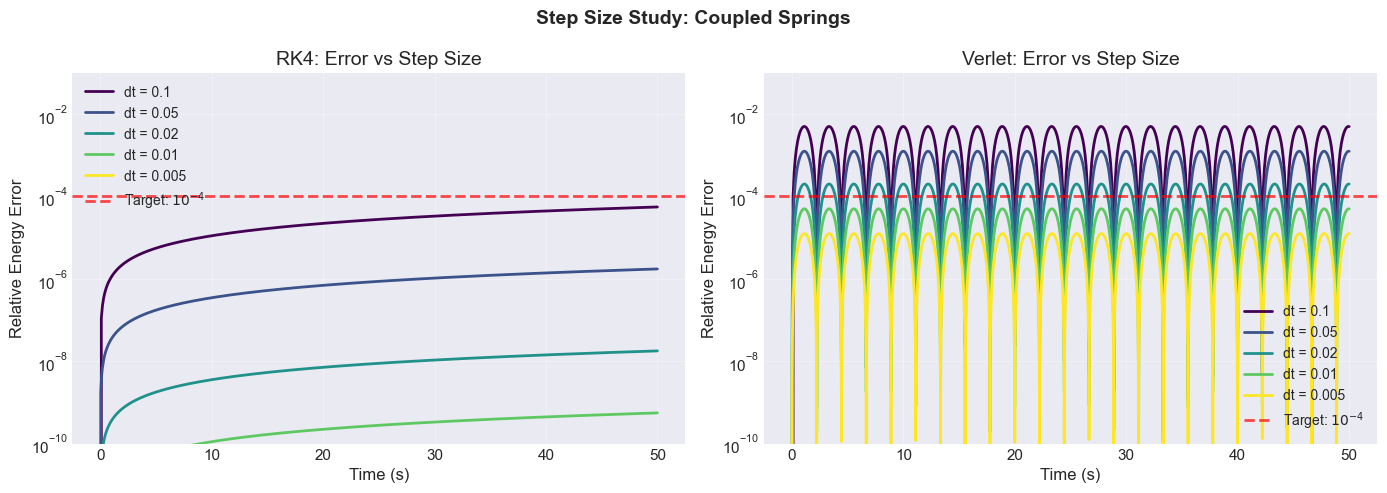


📊 Observations:
  1. Smaller dt → better energy conservation (both methods)
  2. RK4: Error grows linearly in time (accumulates)
  3. Verlet: Error bounded (oscillates but doesn't grow)
  4. For target error 10⁻⁴:
     - RK4 needs dt ≤ 0.02
     - Verlet needs dt ≤ 0.05
  5. Verlet allows LARGER time step for same accuracy!


In [11]:
# Step size analysis for coupled springs

print("="*70)
print("Step Size Analysis: Energy Conservation vs dt")
print("="*70)

dt_values = [0.1, 0.05, 0.02, 0.01, 0.005]
t_span_test = (0, 50)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Step Size Study: Coupled Springs', fontsize=14, fontweight='bold')

colors = plt.cm.viridis(np.linspace(0, 1, len(dt_values)))

print(f"\nTesting {len(dt_values)} different time steps...\n")

for idx, dt_test in enumerate(dt_values):
    # RK4
    t_test, states_test = rk4_solve(state0_springs, t_span_test, dt_test, coupled_springs_derivs)
    x1_test, x2_test = states_test[:, 0], states_test[:, 1]
    v1_test, v2_test = states_test[:, 2], states_test[:, 3]
    E_test = springs_energy(x1_test, x2_test, v1_test, v2_test)
    rel_err_rk4 = np.abs(E_test - E_test[0]) / E_test[0]
    
    # Verlet
    t_test_v, pos_test, vel_test = verlet_solve(
        pos0_springs, vel0_springs, t_span_test, dt_test, coupled_springs_accel
    )
    x1_test_v, x2_test_v = pos_test[:, 0], pos_test[:, 1]
    v1_test_v, v2_test_v = vel_test[:, 0], vel_test[:, 1]
    E_test_v = springs_energy(x1_test_v, x2_test_v, v1_test_v, v2_test_v)
    rel_err_verlet = np.abs(E_test_v - E_test_v[0]) / E_test_v[0]
    
    # Plot
    axes[0].semilogy(t_test, rel_err_rk4, color=colors[idx], 
                     linewidth=2, label=f'dt = {dt_test}')
    axes[1].semilogy(t_test_v, rel_err_verlet, color=colors[idx], 
                     linewidth=2, label=f'dt = {dt_test}')
    
    print(f"dt = {dt_test:5.3f}:")
    print(f"  RK4    - Max error: {rel_err_rk4.max():.2e}, Final: {rel_err_rk4[-1]:.2e}")
    print(f"  Verlet - Max error: {rel_err_verlet.max():.2e}, Final: {rel_err_verlet[-1]:.2e}")

# Target line
target = 1e-4
axes[0].axhline(y=target, color='r', linestyle='--', linewidth=2, label=f'Target: $10^{{-4}}$', alpha=0.7)
axes[1].axhline(y=target, color='r', linestyle='--', linewidth=2, label=f'Target: $10^{{-4}}$', alpha=0.7)

axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Relative Energy Error')
axes[0].set_title('RK4: Error vs Step Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([1e-10, 1e-1])

axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Relative Energy Error')
axes[1].set_title('Verlet: Error vs Step Size')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([1e-10, 1e-1])

plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  1. Smaller dt → better energy conservation (both methods)")
print("  2. RK4: Error grows linearly in time (accumulates)")
print("  3. Verlet: Error bounded (oscillates but doesn't grow)")
print("  4. For target error 10⁻⁴:")
print("     - RK4 needs dt ≤ 0.02")
print("     - Verlet needs dt ≤ 0.05")
print("  5. Verlet allows LARGER time step for same accuracy!")

# Part 5: Summary and Homework Guide

---

## Decision Tree: Which Method to Use?

```
START: I have equations of motion d²x/dt² = a(...)
   |
   ├─ Does acceleration depend on velocity or time explicitly?
   │  ├─ YES (a = a(x,v) or a(x,t)) → Use RK4
   │  │     Examples: Damping, magnetic forces, driven systems
   │  │
   │  └─ NO (a = a(x) only) → Continue...
   │
   ├─ Is energy conserved?
   │  ├─ NO (dissipative system) → Use RK4
   │  │
   │  └─ YES (Hamiltonian system) → Continue...
   │
   ├─ Is simulation long-term (many periods)?
   │  ├─ YES → Use Verlet (excellent energy conservation)
   │  │     YOUR HOMEWORK FITS HERE!
   │  │
   │  └─ NO (short-term) → Either works, RK4 more accurate per step
```
---

## Key Takeaways

| Concept | Summary |
|---------|----------|
| **RK4** | General-purpose, 4th-order, works for any ODE |
| **Verlet** | Symplectic, 2nd-order, ONLY for conservative systems with a=a(x) |
| **Energy conservation** | Verlet maintains bounded error; RK4 accumulates drift |
| **When to use Verlet** | Hamiltonian systems, long-term simulations, a=a(x) only |
| **When to use RK4** | Non-conservative, velocity-dependent forces, short-term high accuracy |
| **Your homework** | Perfect case for comparing both methods! |

---

## Further Reading

1. **Hairer, Lubich, Wanner** - *Geometric Numerical Integration* (the bible of symplectic methods)
2. **Leimkuhler & Reich** - *Simulating Hamiltonian Dynamics*
3. Your lecture notes on numerical methods!

---

**Good luck with your homework!** 🚀

Remember:
- Verlet is your friend for energy conservation
- Always plot energy to verify your implementation
- When in doubt, test with a simple problem first (like harmonic oscillator)

---

In [12]:
print("\n" + "="*70)
print("PSS SESSION COMPLETE")
print("="*70)
print("\nYou now understand:")
print("  ✓ Mathematical foundations of RK4 and Verlet")
print("  ✓ Detailed Leapfrog algorithm derivation")
print("  ✓ When to use each method")
print("  ✓ Energy conservation analysis")
print("  ✓ Step size selection")
print("  ✓ Implementation strategies for your homework")
print("\nReady for Homework 2!" + " 💪" * 3)
print("="*70)


PSS SESSION COMPLETE

You now understand:
  ✓ Mathematical foundations of RK4 and Verlet
  ✓ Detailed Leapfrog algorithm derivation
  ✓ When to use each method
  ✓ Energy conservation analysis
  ✓ Step size selection
  ✓ Implementation strategies for your homework

Ready for Homework 2! 💪 💪 💪
